In [1]:
# Load raw file and convert data into h5 file

from CryoAsicFile import CryoAsicFile

rawfile = '/Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.dat'

channel_map_fn  = './config/localChannelsMap_6mm.txt'
tile_map_fn     = './config/tilesMap_6mm.txt'
outfilename = '/Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.h5'
print(f'Loading {rawfile}...')

cryo_asic_file = CryoAsicFile(rawfile, channel_map_fn, tile_map_fn)
cryo_asic_file.load_raw_data()
cryo_asic_file.group_into_pandas()
cryo_asic_file.save_to_hdf5(outfile=outfilename)

Loading /Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.dat...
Tile IDs in tile map do not match those of channel map exactly:
Chmap tile IDs: [0, 1]
Tile map tile IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171]
Message
 <class 

descrambling event data:   0%|          | 0/116 [00:00<?, ?it/s]

Done loading 116 CRYO ASIC events


Adding waveforms to pandas dataframe:   0%|          | 0/116 [00:00<?, ?it/s]

Saving dataframe to file: /Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.h5


/Users/yumiao/opt/anaconda3/envs/asic/lib/python3.11/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Channels', 'Timestamp', 'Data', 'ChannelTypes', 'ChannelPositions'], dtype='object')]

  pytables.to_hdf(


In [2]:
# calculate noise with Evan's codes
from CryoAsicAnalysis import CryoAsicAnalysis
infile = '/Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.h5'
cryo_asic_analysis = CryoAsicAnalysis(infile, config={'sampling_rate': 2, 'mv_per_adc':0.39, 'key_channel':-1, 'baseline': [0, 20]})
cryo_asic_analysis.baseline_subtract()
cryo_asic_analysis.calculate_avg_psds() # PSD
cryo_asic_analysis.calculate_stds()



loading hdf5 file /Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.h5
Done loading


  0%|          | 0/116 [00:00<?, ?it/s]

Calculating avg PSD on channel...:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating stds on each channel...:   0%|          | 0/64 [00:00<?, ?it/s]

KeyError: 'device_channel'

In [2]:
# Save the calculated STD noise into csv file, to keep the same format with UCSD data for ENC calculation.

import pandas as pd
df_std = pd.DataFrame({'Average Noise': cryo_asic_analysis.noise_df['STD'].to_numpy()})
df_std.to_csv('/Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.csv', )

In [3]:
from CryoAsicENC import ENC_calculator

config = {'capacitance_1' : 22, 'capacitance_2': 39} # These capacitance values are just used to remind me the input capacitance for the two banks, not being used in calculation.
calc = ENC_calculator(config)
calc.set_filename('/Users/yumiao/Documents/Works/0nbb/nEXO/ASIC_SLAC/Data/SN09_nEXOmodified/SN09_nEXOmodified_fullspeed_FEset936_0.csv')
calc.load_noise_csv()

calc.ENC_FC() # full chain ENC
calc.ENC_FE() # front end ENC

float64


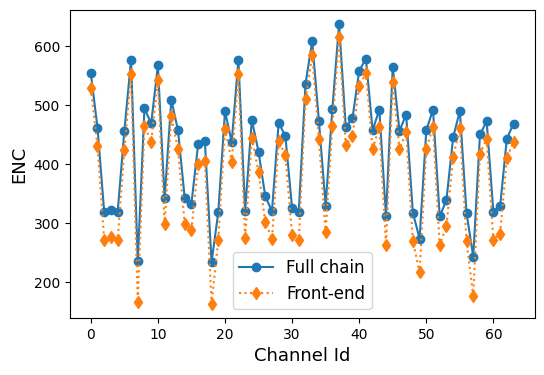

In [7]:
fc_enc, fe_enc = calc.enc_fc, calc.enc_fe
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(6, 4))
ax.plot(fc_enc, 'o-', label='Full chain')
ax.plot(fe_enc, 'd:', label='Front-end')
ax.set_xlabel('Channel Id', fontsize=13)
ax.set_ylabel('ENC', fontsize=13)
ax.legend(prop={'size':12})